In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath(os.path.join("/home/ubuntu/projects/hindsight/examples/data/ast", '../../..')))

import matplotlib.pyplot as plt
import mplfinance as mpf
import jax
import numpy as np

# Data Management imports
from src import DataManager
from src.data.ast.manager import FormulaManager
from src.data.ast.functions import register_built_in_functions, get_function_context
from src.data.core import prepare_for_jit

import xarray as xr

/home/ubuntu/projects/hindsight/src/data/core/struct.py:316: AccessorRegistrationWarning: registration of accessor <class 'src.data.core.struct.DataArrayDateTimeAccessor'> under name 'dt' for type <class 'xarray.core.dataarray.DataArray'> is overriding a preexisting attribute with the same name.
  @xr.register_dataarray_accessor('dt')


In [2]:
# Setup core
data_manager = DataManager()

In [3]:
# Load crypto USDT data
market_data = data_manager.load_builtin(
                    "crypto_standard", 
                    "2019-12-30", 
                    "2024-01-01")['crypto_prices'] # Load USDT Spot data from 2019 to 2024 at HOURLY timeframe

crypto/spot/binance: Attemping to load found cache(/home/suchismit/data/cache/crypto/spot/binance/cdb92fde203902eccc03b671868d4687_2019-01-01_2024-12-31.nc).
crypto/spot/binance: Successfully loaded from /home/suchismit/data/cache/crypto/spot/binance/cdb92fde203902eccc03b671868d4687_2019-01-01_2024-12-31.nc


In [4]:
market_data

<xarray.Dataset> Size: 299MB
Dimensions:       (year: 6, month: 12, day: 31, hour: 24, asset: 265,
                   time_flat: 53568)
Coordinates:
  * year          (year) int32 24B 2019 2020 2021 2022 2023 2024
  * month         (month) int32 48B 1 2 3 4 5 6 7 8 9 10 11 12
  * day           (day) int32 124B 1 2 3 4 5 6 7 8 9 ... 24 25 26 27 28 29 30 31
  * hour          (hour) int32 96B 0 1 2 3 4 5 6 7 8 ... 16 17 18 19 20 21 22 23
  * asset         (asset) <U13 14kB '1000BONKUSDT' '1000BTTCUSDT' ... 'ZRXUSDT'
    time          (year, month, day, hour) datetime64[ns] 429kB 2019-01-01 .....
  * time_flat     (time_flat) int64 429kB 0 1 2 3 4 ... 53564 53565 53566 53567
    mask          (time_flat, asset) bool 14MB False False False ... False False
    mask_indices  (time_flat) int64 429kB 8905 8906 8907 8908 ... -1 -1 -1 -1
Data variables:
    open          (year, month, day, hour, asset) float32 57MB nan nan ... nan
    high          (year, month, day, hour, asset) float32 57MB nan nan ... nan
    low           (year, month, day, hour, asset) float32 57MB nan nan ... nan
    close         (year, month, day, hour, asset) float32 57MB nan nan ... nan
    volume        (year, month, day, hour, asset) float32 57MB nan nan ... nan

In [5]:
md = market_data.dt.to_time_indexed()
md

<xarray.Dataset> Size: 299MB
Dimensions:       (asset: 265, time_flat: 53568, time: 53568)
Coordinates:
  * asset         (asset) <U13 14kB '1000BONKUSDT' '1000BTTCUSDT' ... 'ZRXUSDT'
  * time_flat     (time_flat) int64 429kB 0 1 2 3 4 ... 53564 53565 53566 53567
    mask          (time_flat, asset) bool 14MB False False False ... False False
    mask_indices  (time_flat) int64 429kB 8905 8906 8907 8908 ... -1 -1 -1 -1
  * time          (time) datetime64[ns] 429kB 2019-01-01 ... 2024-12-31T23:00:00
Data variables:
    open          (asset, time) float32 57MB nan nan nan nan ... nan nan nan nan
    high          (asset, time) float32 57MB nan nan nan nan ... nan nan nan nan
    low           (asset, time) float32 57MB nan nan nan nan ... nan nan nan nan
    close         (asset, time) float32 57MB nan nan nan nan ... nan nan nan nan
    volume        (asset, time) float32 57MB nan nan nan nan ... nan nan nan nan

In [13]:
md.sel(asset='BTCUSDT', time='2020-01-07 13:00:00')['open']

<xarray.DataArray 'open' ()> Size: 4B
array(7872.85, dtype=float32)
Coordinates:
    asset    <U13 52B 'BTCUSDT'
    time     datetime64[ns] 8B 2020-01-07T13:00:00

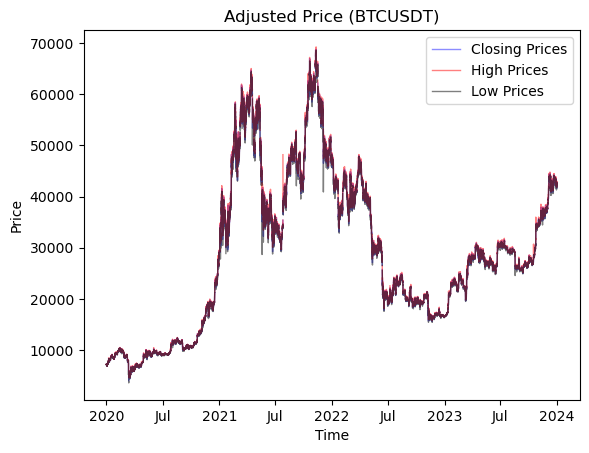

In [5]:
# Let's see BTC/USDT spot closing prices, highs, and lows
btc = market_data[['close', 'high', 'low']].sel(asset='BTCUSDT') 
btc = btc.dt.to_time_indexed()

btc['close'].plot.line(x="time", label='Closing Prices', color='blue', alpha=0.45, lw=1) 
btc['high'].plot.line(x="time", label='High Prices', color='red', alpha=0.5,lw=1) 
btc['low'].plot.line(x="time", label='Low Prices', color='black', alpha=0.5, lw=1) 
plt.title(f"Adjusted Price (BTCUSDT)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(False)

In [6]:
# Compute some characteristics 
# MA for different periods

# Create a closure that captures the static context
def create_jit_evaluator():
    function_context = get_function_context()
    manager = FormulaManager()

    # Capture the static context in the closure
    static_context = {
        "price": "close",
        **function_context
    }
    
    # JIT compile only the dataset processing part
    @jax.jit
    def evaluate_formulas_jit(dataset):
        # Reconstruct the full context inside the JIT function
        context = {
            "_dataset": dataset,
            **static_context
        }
        
        # Multi-configuration evaluation with lag examples
        formula_configs = {
            "hma": [
                {"window": 100},
                {"window": 200}
            ],
        }
        
        return manager.evaluate_bulk(formula_configs, context)
    
    return evaluate_formulas_jit

# Prepare data for JIT, since some vars are not JIT compatible. For example, strings.
market_data_jit, recover = prepare_for_jit(market_data)

evaluate_formulas_jit = create_jit_evaluator()
results = evaluate_formulas_jit(market_data_jit)

results

<xarray.Dataset> Size: 186MB
Dimensions:       (hour: 24, time_flat: 53568, asset: 265, day: 31, year: 6,
                   month: 12)
Coordinates:
  * hour          (hour) int32 96B 0 1 2 3 4 5 6 7 8 ... 16 17 18 19 20 21 22 23
    mask          (time_flat, asset) bool 14MB False False False ... False False
  * asset         (asset) object 2kB '1000BONKUSDT' '1000BTTCUSDT' ... 'ZRXUSDT'
  * day           (day) int32 124B 1 2 3 4 5 6 7 8 9 ... 24 25 26 27 28 29 30 31
  * time_flat     (time_flat) int64 429kB 0 1 2 3 4 ... 53564 53565 53566 53567
  * year          (year) int32 24B 2019 2020 2021 2022 2023 2024
  * month         (month) int32 48B 1 2 3 4 5 6 7 8 9 10 11 12
    mask_indices  (time_flat) int64 429kB 8905 8906 8907 8908 ... -1 -1 -1 -1
    time          (year, month, day, hour) datetime64[ns] 429kB 2019-01-01 .....
Data variables:
    hma_ww100     (asset, year, month, day, hour) float32 57MB ...
    hma_ww200     (asset, year, month, day, hour) float32 57MB ...
    wma           (asset, year, month, day, hour) float32 57MB ...

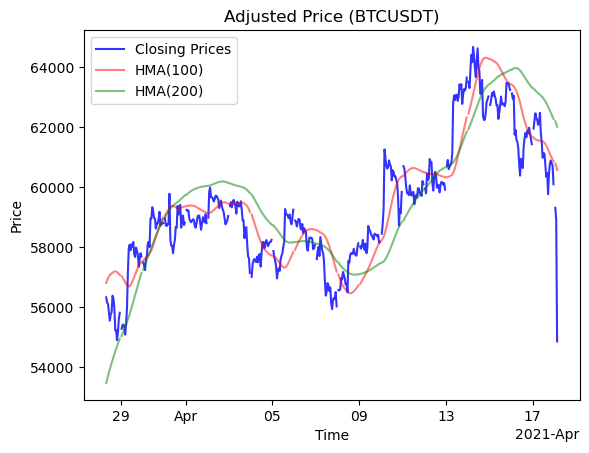

In [7]:
# Let's see BTC/USDT spot closing prices, highs, and lows
indices = slice(20_000, 20_500)

hmas = results[['hma_ww100', 'hma_ww200']].sel(asset='BTCUSDT') 
hmas = hmas.dt.to_time_indexed().isel(time=indices)

btc.isel(time=indices)['close'].plot.line(x="time", label='Closing Prices', color='blue', alpha=0.8) 
hmas['hma_ww100'].plot.line(x="time", label='HMA(100)', color='red', alpha=0.5)
hmas['hma_ww200'].plot.line(x="time", label='HMA(200)', color='green', alpha=0.5) 
plt.title(f"Adjusted Price (BTCUSDT)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(False)

In [8]:
# Backtester imports
from src.backtester.core import BacktestState, BaseStrategy, BacktestEngine

class BUYHLDBitcoin(BaseStrategy):

    def __init__(self):
        super().__init__("Buy and Hold Bitcoin Strategy", window_size=1)

    def next(self, market_data, characteristics, state):
        
        # Create new positions DataArray with same structure as current positions
        new_positions = state.positions.copy()
        
        new_positions.loc[dict(asset='BTCUSDT')] = 1.0  # Set position to 100%
            
        return new_positions

In [ ]:
engine = BacktestEngine(
    strategy        = BUYHLDBitcoin(),
    market_data     = market_data,
    characteristics = results,
    verbose         = True
)

Pre-computing windows(window_size=1):  76%|█████████████████████████████         | 40902/53568 [00:49<00:14, 882.46it/s]

In [10]:
state = engine.run()

Backtesting:  28%|█████████████████▍                                             | 14803/53568 [01:39<04:19, 149.50it/s]


KeyboardInterrupt: 

In [ ]:
state.all_positions.sel(asset='BTCUSDT')[5000:5100]

In [ ]:
state.cumulative_returns

In [ ]:
# Let's see BTC/USDT

state.cumulative_returns.plot.line(x="time_flat", label='Cumulative returns', color='blue', alpha=0.5) 
plt.title(f"BTCUSDT HLD")
plt.xlabel("Time")
plt.ylabel("log returns")
plt.legend()
plt.grid(False)

In [ ]:
class TestBTCUSDT(BaseStrategy):
    
    def __init__(self):
        super().__init__("Buy BTC then Sell Strategy", window_size=1)
        self.buy_timestep = 2   # Buy on 3rd timestep (0-indexed)
        self.sell_timestep = 7  # Sell on 8th timestep
    
    def next(self, market_data, characteristics, state):
        current_timestep = state.timestamp_idx
        n_assets = len(market_data.asset)
                
        new_positions = state.positions.copy()
        
        if current_timestep == self.buy_timestep:
            # Buy 50% BTC (assuming BTCUSDT is first asset)
            print("BUY 50% BTC")
            new_positions.loc[dict(asset='BTCUSDT')] = 0.5  # 50% weight in first asset
            
        elif current_timestep == self.sell_timestep:
            # Sell everything (go to cash)
            print("SELL ALL")
            new_positions.loc[dict(asset='BTCUSDT')] = 0.0
            # new_positions remains all zeros = 100% cash
            
        else:
            # Hold current positions
            print("HOLD")
            if state.total_portfolio_value > 0:
                # Calculate current weights to maintain positions
                current_positions = state.positions[0, :]
                current_prices = market_data.isel(time=state.timestamp_idx, time_flat=state.timestamp_idx)['open']
                current_dollar_values = current_positions * current_prices
                current_weights = current_dollar_values / state.total_portfolio_value
                new_positions[0, :] = current_weights
        
        return new_positions

# Engine setup
engine = BacktestEngine(
    strategy=TestBTCUSDT(),
    market_data=market_data,
    characteristics=results,  # or characteristics
    initial_cash=100000.0,
    commission_rate=0.001  # 0.1% commission
)

state = engine.run()